# Sistema de Monitoreo de Salud - Módulo de Machine Learning
## Predicción de Anomalías en Frecuencia Cardíaca

Este notebook implementa el modelo de ML para detectar anomalías en la frecuencia cardíaca
de acuerdo a los requerimientos del SRS v2.0

## 1. Importación de Librerías

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.cluster import DBSCAN

# Deep Learning (opcional para detección de anomalías)
try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout
    TENSORFLOW_AVAILABLE = True
except:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow no disponible. Se usarán solo modelos sklearn.")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Carga y Exploración de Datos

In [82]:
# Cargar el dataset
df = pd.read_csv(r'C:\Users\acer\Desktop\Proyectos\Artemis\ML\Dataset\unclean_smartwatch_health_data.csv')

print("=" * 60)
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"\nDimensiones: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())
print(f"\nInformación general:")
print(df.info())
print(f"\nEstadísticas descriptivas:")
print(df.describe())

INFORMACIÓN DEL DATASET

Dimensiones: (10000, 7)

Primeras filas:
   User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0   4174.0         58.939776               98.809650   5450.390578   
1      NaN               NaN               98.532195    727.601610   
2   1860.0        247.803052               97.052954   2826.521994   
3   2294.0         40.000000               96.894213  13797.338040   
4   2130.0         61.950165               98.583797  15679.067650   

  Sleep Duration (hours) Activity Level Stress Level  
0            7.167235622  Highly Active            1  
1            6.538239376  Highly_Active            5  
2                  ERROR  Highly Active            5  
3             7.36778963          Actve            3  
4                    NaN  Highly_Active            6  

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
-

In [83]:
# Verificar valores nulos
print("\n" + "=" * 60)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 60)
print(df.isnull().sum())
print(f"\nPorcentaje de valores nulos por columna:")
print((df.isnull().sum() / len(df) * 100).round(2))


ANÁLISIS DE VALORES NULOS
User ID                   201
Heart Rate (BPM)          400
Blood Oxygen Level (%)    300
Step Count                100
Sleep Duration (hours)    150
Activity Level            200
Stress Level              200
dtype: int64

Porcentaje de valores nulos por columna:
User ID                   2.01
Heart Rate (BPM)          4.00
Blood Oxygen Level (%)    3.00
Step Count                1.00
Sleep Duration (hours)    1.50
Activity Level            2.00
Stress Level              2.00
dtype: float64


## 3. Limpieza y Preprocesamiento de Datos

In [84]:
# Crear una copia para trabajar
df_clean = df.copy()

# Renombrar columnas para facilitar el trabajo
df_clean.columns = df_clean.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('%', 'pct')

# Verificar nombres de columnas
print("Columnas en el dataset:")
print(df_clean.columns.tolist())

# Enfoque principal en Heart Rate (HR)
print("\n" + "=" * 60)
print("ANÁLISIS DE FRECUENCIA CARDÍACA (HR)")
print("=" * 60)

# Estadísticas de HR
hr_stats = df_clean['heart_rate_bpm'].describe()
print(f"\nEstadísticas de Heart Rate:")
print(hr_stats)

# Identificar valores atípicos en HR
Q1 = df_clean['heart_rate_bpm'].quantile(0.25)
Q3 = df_clean['heart_rate_bpm'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nRangos normales calculados:")
print(f"Límite inferior: {lower_bound:.2f} bpm")
print(f"Límite superior: {upper_bound:.2f} bpm")

outliers = df_clean[(df_clean['heart_rate_bpm'] < lower_bound) | 
                     (df_clean['heart_rate_bpm'] > upper_bound)]
print(f"\nValores atípicos detectados: {len(outliers)} ({len(outliers)/len(df_clean)*100:.2f}%)")

Columnas en el dataset:
['user_id', 'heart_rate_bpm', 'blood_oxygen_level_pct', 'step_count', 'sleep_duration_hours', 'activity_level', 'stress_level']

ANÁLISIS DE FRECUENCIA CARDÍACA (HR)

Estadísticas de Heart Rate:
count    9600.000000
mean       76.035462
std        19.412483
min        40.000000
25%        64.890152
50%        75.220601
75%        85.198249
max       296.593970
Name: heart_rate_bpm, dtype: float64

Rangos normales calculados:
Límite inferior: 34.43 bpm
Límite superior: 115.66 bpm

Valores atípicos detectados: 75 (0.75%)


In [85]:
# Tratamiento de valores nulos en HR
print(f"\nValores nulos en heart_rate antes: {df_clean['heart_rate_bpm'].isnull().sum()}")

# Rellenar con interpolación
df_clean['heart_rate_bpm'] = df_clean['heart_rate_bpm'].interpolate(method='linear')

# Si aún quedan nulos, rellenar con la mediana
if df_clean['heart_rate_bpm'].isnull().sum() > 0:
    df_clean['heart_rate_bpm'].fillna(df_clean['heart_rate_bpm'].median(), inplace=True)

print(f"Valores nulos en heart_rate después: {df_clean['heart_rate_bpm'].isnull().sum()}")

# Renombrar para simplificar
df_clean['heart_rate'] = df_clean['heart_rate_bpm']


Valores nulos en heart_rate antes: 400
Valores nulos en heart_rate después: 0


## 4. Feature Engineering

In [86]:
# Crear características adicionales basadas en HR
print("\n" + "=" * 60)
print("INGENIERÍA DE CARACTERÍSTICAS")
print("=" * 60)

# 1. Estadísticas móviles
df_clean['hr_rolling_mean_5'] = df_clean['heart_rate'].rolling(window=5, min_periods=1).mean()
df_clean['hr_rolling_std_5'] = df_clean['heart_rate'].rolling(window=5, min_periods=1).std()
df_clean['hr_rolling_mean_10'] = df_clean['heart_rate'].rolling(window=10, min_periods=1).mean()

# 2. Diferencias (cambios en HR)
df_clean['hr_diff'] = df_clean['heart_rate'].diff()
df_clean['hr_diff_abs'] = df_clean['hr_diff'].abs()

# 3. Ratios
median_hr = df_clean['heart_rate'].median()
df_clean['hr_ratio_to_median'] = df_clean['heart_rate'] / median_hr

# 4. Categorización de zonas cardíacas (basado en % de HR máxima teórica)
# Asumiendo usuarios adultos, HR_max ≈ 220 - edad (usaremos 190 como promedio)
df_clean['hr_zone'] = pd.cut(df_clean['heart_rate'], 
                               bins=[0, 100, 130, 150, 170, 300],
                               labels=['Reposo', 'Ligera', 'Moderada', 'Intensa', 'Máxima'])

# 5. Detección de cambios bruscos
df_clean['hr_sudden_change'] = (df_clean['hr_diff_abs'] > 20).astype(int)

# Rellenar NaN generados por las operaciones
for col in df_clean.select_dtypes(include=[np.number]).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

print("Características creadas:")
print(df_clean.columns.tolist())
print(f"\nNuevas dimensiones: {df_clean.shape}")


INGENIERÍA DE CARACTERÍSTICAS
Características creadas:
['user_id', 'heart_rate_bpm', 'blood_oxygen_level_pct', 'step_count', 'sleep_duration_hours', 'activity_level', 'stress_level', 'heart_rate', 'hr_rolling_mean_5', 'hr_rolling_std_5', 'hr_rolling_mean_10', 'hr_diff', 'hr_diff_abs', 'hr_ratio_to_median', 'hr_zone', 'hr_sudden_change']

Nuevas dimensiones: (10000, 16)


## 4.1. Detección de Patrones de Estrés (SRS: Risk Detection and Prediction)

In [87]:
"""
REQUERIMIENTO SRS FR-004: Risk Detection and Prediction
"The Machine Learning module must process biometric data to detect patterns 
that indicate stress on the officers."

Este módulo detecta patrones de estrés basándose en:
- Variabilidad de HR (HRV): baja variabilidad = alto estrés
- HR elevada sostenida: indicador de estrés prolongado
- Cambios bruscos frecuentes: estrés agudo
- Desviación del baseline personal
"""

print("\n" + "=" * 60)
print("DETECCIÓN DE PATRONES DE ESTRÉS")
print("=" * 60)

def create_stress_indicators(df):
    """
    Crea indicadores de estrés basados en literatura médica
    
    Returns:
        DataFrame con nuevas columnas:
        - hr_variability: variabilidad de HR (HRV)
        - hr_elevated_sustained: HR sostenidamente alta
        - hr_rapid_changes: frecuencia de cambios bruscos
        - stress_score: score de estrés 0-100
        - stress_level: categoría de estrés
        - high_stress_risk: indicador binario de alto riesgo
    """
    
    # 1. Variabilidad de HR (HRV) - Indicador clave de estrés
    # Baja variabilidad = Alto estrés | Alta variabilidad = Bajo estrés
    df['hr_variability'] = df['hr_rolling_std_5'] / df['hr_rolling_mean_5']
    
    # 2. HR elevada sostenida (>100 bpm por período prolongado)
    df['hr_elevated_sustained'] = (
        (df['heart_rate'] > 100) & 
        (df['hr_rolling_mean_10'] > 100)
    ).astype(int)
    
    # 3. Cambios bruscos frecuentes (ventana de 5 lecturas)
    df['hr_rapid_changes'] = df['hr_sudden_change'].rolling(
        window=5, min_periods=1
    ).sum()
    
    # 4. Desviación del baseline personal
    personal_baseline = df['heart_rate'].median()
    df['hr_deviation_from_baseline'] = abs(df['heart_rate'] - personal_baseline)
    
    # 5. Score de Estrés Combinado (0-100)
    # Normalizar componentes
    hr_min, hr_max = df['heart_rate'].min(), df['heart_rate'].max()
    hr_norm = (df['heart_rate'] - hr_min) / (hr_max - hr_min)
    
    # Manejar valores nulos en variabilidad
    df['hr_variability'].fillna(df['hr_variability'].median(), inplace=True)
    hrv_min, hrv_max = df['hr_variability'].min(), df['hr_variability'].max()
    
    # Invertir HRV: baja variabilidad = alto estrés
    hrv_norm = 1 - ((df['hr_variability'] - hrv_min) / (hrv_max - hrv_min))
    
    # Normalizar cambios rápidos
    changes_max = df['hr_rapid_changes'].max()
    changes_norm = df['hr_rapid_changes'] / changes_max if changes_max > 0 else 0
    
    # Score ponderado (basado en importancia clínica)
    df['stress_score'] = (
        hr_norm * 0.40 +        # 40% - HR absoluta
        hrv_norm * 0.35 +       # 35% - Variabilidad (invertida)
        changes_norm * 0.25     # 25% - Cambios bruscos
    ) * 100
    
    # 6. Clasificación por niveles
    df['stress_level'] = pd.cut(
        df['stress_score'],
        bins=[0, 30, 50, 70, 85, 100],
        labels=['Muy Bajo', 'Bajo', 'Moderado', 'Alto', 'Muy Alto']
    )
    
    # 7. Indicador binario de ALTO RIESGO (para modelado)
    df['high_stress_risk'] = (df['stress_score'] > 70).astype(int)
    
    return df

# Aplicar detección de estrés
df_clean = create_stress_indicators(df_clean)

# Rellenar cualquier NaN remanente
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Reportar resultados
print("\nINDICADORES DE ESTRÉS CREADOS:")
print(f"Score de estrés promedio: {df_clean['stress_score'].mean():.2f}/100")
print(f"Score de estrés mediano: {df_clean['stress_score'].median():.2f}/100")
print(f"Rango: {df_clean['stress_score'].min():.2f} - {df_clean['stress_score'].max():.2f}")

print("\nDISTRIBUCIÓN DE NIVELES DE ESTRÉS:")
stress_dist = df_clean['stress_level'].value_counts().sort_index()
for level, count in stress_dist.items():
    pct = (count / len(df_clean)) * 100
    emoji = '🟢' if level in ['Muy Bajo', 'Bajo'] else '🟡' if level == 'Moderado' else '🟠' if level == 'Alto' else '🔴'
    print(f"  {emoji} {level}: {count:,} ({pct:.2f}%)")

high_risk_count = df_clean['high_stress_risk'].sum()
high_risk_pct = (high_risk_count / len(df_clean)) * 100
print(f"\nOFICIALES EN ALTO RIESGO: {high_risk_count:,} ({high_risk_pct:.2f}%)")

# Estadísticas de HR por nivel de estrés
print("\nESTADÍSTICAS DE HR POR NIVEL DE ESTRÉS:")
hr_by_stress = df_clean.groupby('stress_level')['heart_rate'].agg(['mean', 'std', 'min', 'max'])
print(hr_by_stress.round(2))


DETECCIÓN DE PATRONES DE ESTRÉS

INDICADORES DE ESTRÉS CREADOS:
Score de estrés promedio: 42.01/100
Score de estrés mediano: 41.80/100
Rango: 13.16 - 65.94

DISTRIBUCIÓN DE NIVELES DE ESTRÉS:
  🟢 Muy Bajo: 138 (1.38%)
  🟢 Bajo: 9,025 (90.25%)
  🟡 Moderado: 837 (8.37%)
  🟠 Alto: 0 (0.00%)
  🔴 Muy Alto: 0 (0.00%)

OFICIALES EN ALTO RIESGO: 0 (0.00%)

ESTADÍSTICAS DE HR POR NIVEL DE ESTRÉS:
               mean    std    min     max
stress_level                             
Muy Bajo      63.61  15.53  40.00  100.47
Bajo          74.52  15.69  40.00  296.59
Moderado      93.74  36.49  42.92  292.92
Alto            NaN    NaN    NaN     NaN
Muy Alto        NaN    NaN    NaN     NaN


## 4.2. Visualización de Patrones de Estrés

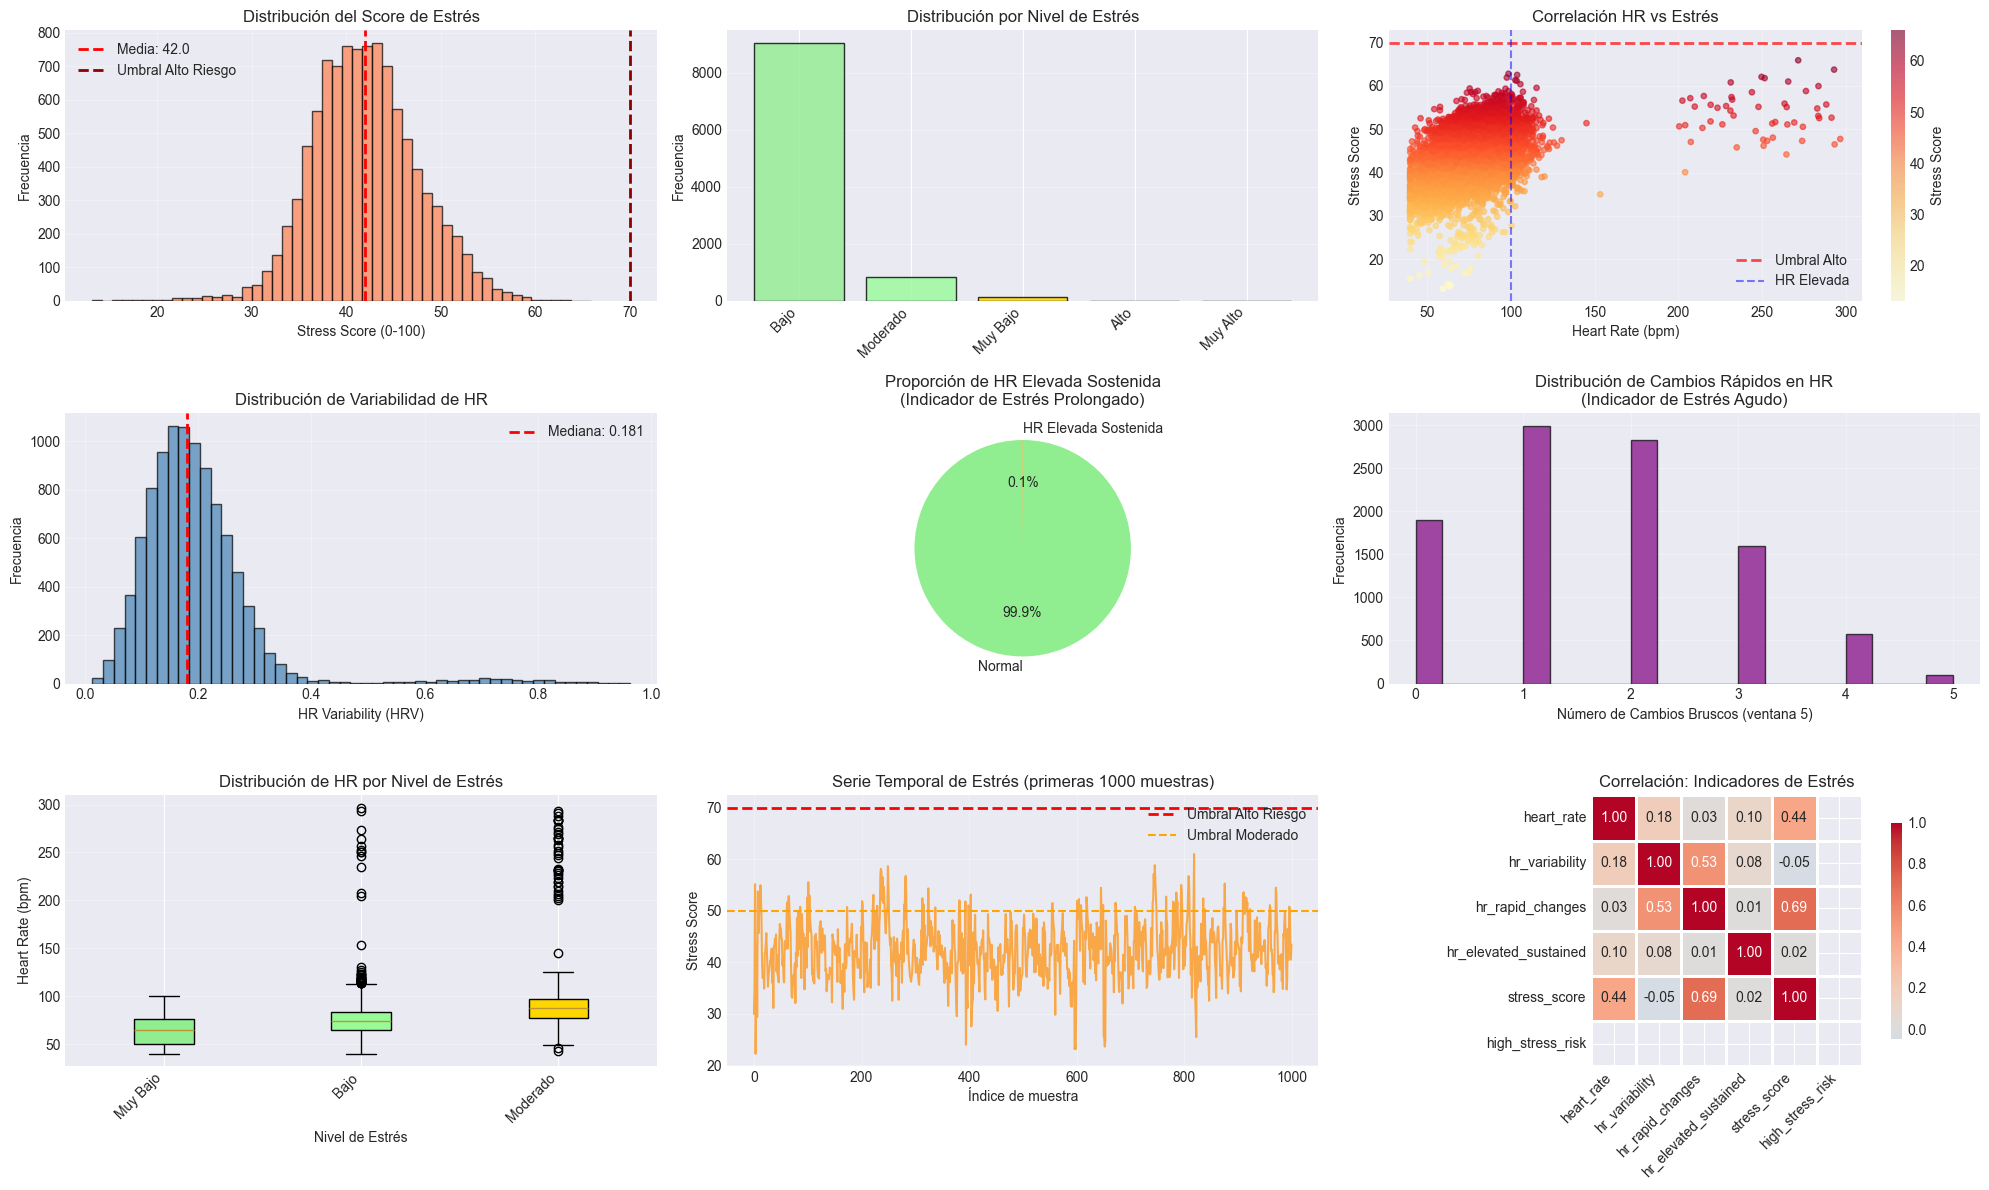


Gráfico guardado como 'stress_pattern_analysis.png'


In [88]:
fig = plt.figure(figsize=(20, 12))

# 1. Distribución del Score de Estrés
plt.subplot(3, 3, 1)
plt.hist(df_clean['stress_score'], bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.axvline(df_clean['stress_score'].mean(), color='red', linestyle='--', 
            label=f'Media: {df_clean["stress_score"].mean():.1f}', linewidth=2)
plt.axvline(70, color='darkred', linestyle='--', label='Umbral Alto Riesgo', linewidth=2)
plt.xlabel('Stress Score (0-100)')
plt.ylabel('Frecuencia')
plt.title('Distribución del Score de Estrés')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Niveles de Estrés
plt.subplot(3, 3, 2)
stress_counts = df_clean['stress_level'].value_counts()
colors_stress = ['#90EE90', '#98FB98', '#FFD700', '#FF8C00', '#FF4500']
plt.bar(range(len(stress_counts)), stress_counts.values, 
        color=colors_stress[:len(stress_counts)], edgecolor='black', alpha=0.8)
plt.xticks(range(len(stress_counts)), stress_counts.index, rotation=45, ha='right')
plt.ylabel('Frecuencia')
plt.title('Distribución por Nivel de Estrés')
plt.grid(True, alpha=0.3, axis='y')

# 3. HR vs Stress Score
plt.subplot(3, 3, 3)
scatter = plt.scatter(df_clean['heart_rate'], df_clean['stress_score'], 
                     c=df_clean['stress_score'], cmap='YlOrRd', alpha=0.6, s=15)
plt.colorbar(scatter, label='Stress Score')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Stress Score')
plt.title('Correlación HR vs Estrés')
plt.axhline(70, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Umbral Alto')
plt.axvline(100, color='blue', linestyle='--', alpha=0.5, label='HR Elevada')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Variabilidad de HR (HRV)
plt.subplot(3, 3, 4)
plt.hist(df_clean['hr_variability'], bins=50, color='steelblue', 
         edgecolor='black', alpha=0.7)
plt.xlabel('HR Variability (HRV)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Variabilidad de HR')
plt.axvline(df_clean['hr_variability'].median(), color='red', linestyle='--', 
            label=f'Mediana: {df_clean["hr_variability"].median():.3f}', linewidth=2)
plt.legend()
plt.grid(True, alpha=0.3)

# 5. HR Elevada Sostenida
plt.subplot(3, 3, 5)
elevated_counts = df_clean['hr_elevated_sustained'].value_counts()
labels_elevated = ['Normal', 'HR Elevada Sostenida']
colors_elevated = ['#90EE90', '#FF8C00']
plt.pie(elevated_counts.values, labels=labels_elevated, autopct='%1.1f%%',
        colors=colors_elevated, startangle=90, textprops={'fontsize': 10})
plt.title('Proporción de HR Elevada Sostenida\n(Indicador de Estrés Prolongado)')

# 6. Cambios Rápidos en HR
plt.subplot(3, 3, 6)
plt.hist(df_clean['hr_rapid_changes'], bins=20, color='purple', 
         edgecolor='black', alpha=0.7)
plt.xlabel('Número de Cambios Bruscos (ventana 5)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Cambios Rápidos en HR\n(Indicador de Estrés Agudo)')
plt.grid(True, alpha=0.3)

# 7. Boxplot: HR por Nivel de Estrés
plt.subplot(3, 3, 7)
stress_levels_ordered = ['Muy Bajo', 'Bajo', 'Moderado', 'Alto', 'Muy Alto']
data_boxplot = [df_clean[df_clean['stress_level'] == level]['heart_rate'].values 
                for level in stress_levels_ordered if level in df_clean['stress_level'].values]
bp = plt.boxplot(data_boxplot, labels=[l for l in stress_levels_ordered if l in df_clean['stress_level'].values],
                 patch_artist=True)
for patch, color in zip(bp['boxes'], colors_stress):
    patch.set_facecolor(color)
plt.xlabel('Nivel de Estrés')
plt.ylabel('Heart Rate (bpm)')
plt.title('Distribución de HR por Nivel de Estrés')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# 8. Serie Temporal de Stress Score
plt.subplot(3, 3, 8)
sample_stress = min(1000, len(df_clean))
plt.plot(df_clean['stress_score'].head(sample_stress), 
         color='darkorange', alpha=0.7, linewidth=1.5)
plt.axhline(70, color='red', linestyle='--', linewidth=2, label='Umbral Alto Riesgo')
plt.axhline(50, color='orange', linestyle='--', linewidth=1.5, label='Umbral Moderado')
plt.xlabel('Índice de muestra')
plt.ylabel('Stress Score')
plt.title(f'Serie Temporal de Estrés (primeras {sample_stress} muestras)')
plt.legend()
plt.grid(True, alpha=0.3)

# 9. Correlación: Indicadores de Estrés
plt.subplot(3, 3, 9)
stress_features = ['heart_rate', 'hr_variability', 'hr_rapid_changes', 
                   'hr_elevated_sustained', 'stress_score', 'high_stress_risk']
corr_stress = df_clean[stress_features].corr()
sns.heatmap(corr_stress, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlación: Indicadores de Estrés')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('stress_pattern_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado como 'stress_pattern_analysis.png'")

---

## 5. Actualización de Features para Modelos

Ahora que hemos creado indicadores de estrés adicionales, vamos a actualizar las columnas de features que usaremos para entrenar/refinar nuestros modelos.

In [89]:
# Features actualizadas incluyendo indicadores de estrés
feature_columns_extended = [
    'heart_rate',
    'hr_rolling_mean_5',
    'hr_rolling_std_5',
    'hr_rolling_mean_10',
    'hr_diff_abs',
    'hr_ratio_to_median',
    'hr_variability',       # Nuevo: HRV como indicador de estrés
    'hr_rapid_changes',     # Nuevo: Cambios bruscos en ventana de 5
    'stress_score'          # Nuevo: Score compuesto de estrés
]

print("Features extendidas para entrenamiento:")
print(f"   Total: {len(feature_columns_extended)} features")
print(f"   Nuevas features de estrés: {['hr_variability', 'hr_rapid_changes', 'stress_score']}")

# Verificar que todas las features existen
missing_features = [col for col in feature_columns_extended if col not in df_clean.columns]
if missing_features:
    print(f"Features faltantes: {missing_features}")
else:
    print(f"Todas las features están disponibles en df_clean")

Features extendidas para entrenamiento:
   Total: 9 features
   Nuevas features de estrés: ['hr_variability', 'hr_rapid_changes', 'stress_score']
Todas las features están disponibles en df_clean


## 5. Visualización de Datos

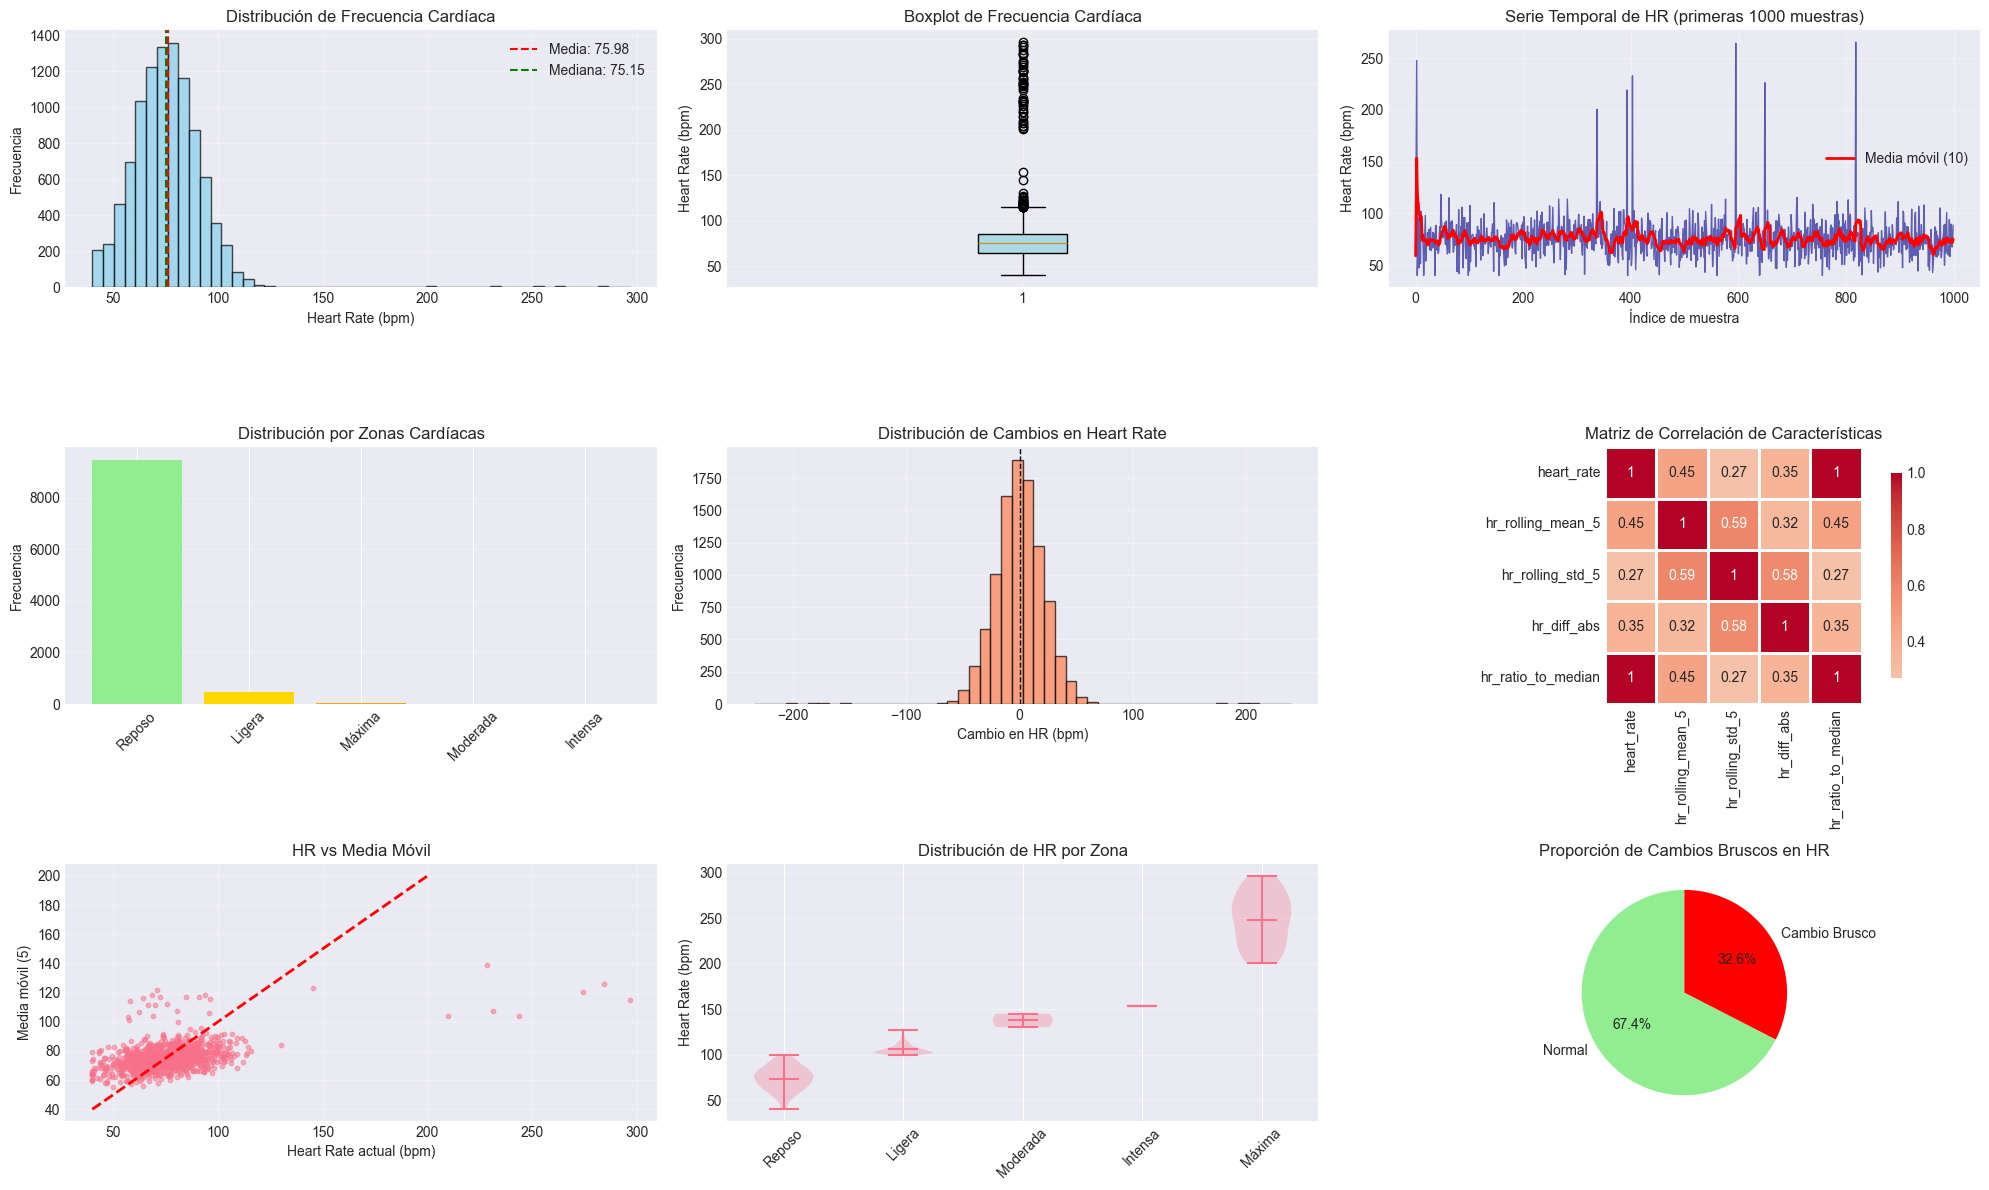


Gráfico guardado como 'hr_analysis_comprehensive.png'


In [90]:
# Configurar el estilo de los gráficos
fig = plt.figure(figsize=(20, 12))

# 1. Distribución de Heart Rate
plt.subplot(3, 3, 1)
plt.hist(df_clean['heart_rate'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(df_clean['heart_rate'].mean(), color='red', linestyle='--', label=f'Media: {df_clean["heart_rate"].mean():.2f}')
plt.axvline(df_clean['heart_rate'].median(), color='green', linestyle='--', label=f'Mediana: {df_clean["heart_rate"].median():.2f}')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Frecuencia Cardíaca')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Boxplot de HR
plt.subplot(3, 3, 2)
box = plt.boxplot(df_clean['heart_rate'], vert=True, patch_artist=True)
box['boxes'][0].set_facecolor('lightblue')
plt.ylabel('Heart Rate (bpm)')
plt.title('Boxplot de Frecuencia Cardíaca')
plt.grid(True, alpha=0.3)

# 3. Serie temporal de HR (muestra)
plt.subplot(3, 3, 3)
sample_size = min(1000, len(df_clean))
plt.plot(df_clean['heart_rate'].head(sample_size), color='darkblue', alpha=0.6, linewidth=1)
plt.plot(df_clean['hr_rolling_mean_10'].head(sample_size), color='red', linewidth=2, label='Media móvil (10)')
plt.xlabel('Índice de muestra')
plt.ylabel('Heart Rate (bpm)')
plt.title(f'Serie Temporal de HR (primeras {sample_size} muestras)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Distribución por zonas cardíacas
plt.subplot(3, 3, 4)
zone_counts = df_clean['hr_zone'].value_counts()
colors_zones = ['#90EE90', '#FFD700', '#FFA500', '#FF6347', '#8B0000']
plt.bar(range(len(zone_counts)), zone_counts.values, color=colors_zones[:len(zone_counts)])
plt.xticks(range(len(zone_counts)), zone_counts.index, rotation=45)
plt.ylabel('Frecuencia')
plt.title('Distribución por Zonas Cardíacas')
plt.grid(True, alpha=0.3, axis='y')

# 5. Cambios en HR (diferencias)
plt.subplot(3, 3, 5)
plt.hist(df_clean['hr_diff'].dropna(), bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Cambio en HR (bpm)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Cambios en Heart Rate')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)

# 6. Correlación entre características
plt.subplot(3, 3, 6)
features_for_corr = ['heart_rate', 'hr_rolling_mean_5', 'hr_rolling_std_5', 
                     'hr_diff_abs', 'hr_ratio_to_median']
corr_matrix = df_clean[features_for_corr].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Características')

# 7. Scatter plot: HR vs Rolling Mean
plt.subplot(3, 3, 7)
sample_indices = np.random.choice(len(df_clean), min(1000, len(df_clean)), replace=False)
plt.scatter(df_clean.iloc[sample_indices]['heart_rate'], 
            df_clean.iloc[sample_indices]['hr_rolling_mean_5'],
            alpha=0.5, s=10)
plt.xlabel('Heart Rate actual (bpm)')
plt.ylabel('Media móvil (5)')
plt.title('HR vs Media Móvil')
plt.plot([40, 200], [40, 200], 'r--', linewidth=2)
plt.grid(True, alpha=0.3)

# 8. Violinplot de HR por zona
plt.subplot(3, 3, 8)
# Crear datos para violin plot
zones_for_violin = df_clean.groupby('hr_zone')['heart_rate'].apply(list)
positions = range(len(zones_for_violin))
plt.violinplot([zones_for_violin[zone] for zone in zones_for_violin.index], 
               positions=positions, showmeans=True)
plt.xticks(positions, zones_for_violin.index, rotation=45)
plt.ylabel('Heart Rate (bpm)')
plt.title('Distribución de HR por Zona')
plt.grid(True, alpha=0.3, axis='y')

# 9. Cambios bruscos detectados
plt.subplot(3, 3, 9)
sudden_changes = df_clean['hr_sudden_change'].value_counts()
plt.pie(sudden_changes.values, labels=['Normal', 'Cambio Brusco'], 
        autopct='%1.1f%%', colors=['lightgreen', 'red'], startangle=90)
plt.title('Proporción de Cambios Bruscos en HR')

plt.tight_layout()
plt.savefig('hr_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado como 'hr_analysis_comprehensive.png'")

## 6. Preparación de Datos para Modelos

In [ ]:
# Seleccionar características para el modelo (ACTUALIZADAS CON FEATURES DE ESTRÉS)
feature_columns = [
    'heart_rate',
    'hr_rolling_mean_5',
    'hr_rolling_std_5',
    'hr_rolling_mean_10',
    'hr_diff_abs',
    'hr_ratio_to_median',
    'hr_variability',       # ← Feature de estrés (HRV)
    'hr_rapid_changes',     # ← Feature de estrés (cambios bruscos)
    'stress_score'          # ← Feature de estrés (score combinado)
]

X = df_clean[feature_columns].copy()

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

print("=" * 60)
print("DATOS PREPARADOS PARA MODELADO (CON FEATURES DE ESTRÉS)")
print("=" * 60)
print(f"Características seleccionadas: {len(feature_columns)} features")
print(f"Features: {feature_columns}")
print(f"Forma de X: {X_scaled.shape}")
print(f"\nPrimeras filas de datos normalizados:")
print(X_scaled_df.head())

DATOS PREPARADOS PARA MODELADO
Características seleccionadas: ['heart_rate', 'hr_rolling_mean_5', 'hr_rolling_std_5', 'hr_rolling_mean_10', 'hr_diff_abs', 'hr_ratio_to_median']
Forma de X: (10000, 6)

Primeras filas de datos normalizados:
   heart_rate  hr_rolling_mean_5  hr_rolling_std_5  hr_rolling_mean_10  \
0   -0.889039          -1.947824         -0.154770           -2.737452   
1    4.038196           3.447935          4.479384            4.841074   
2    8.965431           8.843695          6.884003           12.419600   
3   -1.877275           5.604712          6.994123            7.870339   
4   -0.731964           4.163010          6.285412            5.845420   

   hr_diff_abs  hr_ratio_to_median  
0    -0.205677           -0.889039  
1     3.808825            4.038196  
2     3.808825            8.965431  
3     9.429925           -1.877275  
4     0.215101           -0.731964  


## 7. Modelo 1: Isolation Forest para Detección de Anomalías

In [92]:
print("\n" + "=" * 60)
print("MODELO 1: ISOLATION FOREST")
print("=" * 60)

# Entrenar Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,  # 5% de anomalías esperadas
    random_state=42,
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1
)

# Predecir anomalías (-1 = anomalía, 1 = normal)
df_clean['anomaly_if'] = iso_forest.fit_predict(X_scaled)
df_clean['anomaly_score_if'] = iso_forest.score_samples(X_scaled)

# Convertir a binario (0 = normal, 1 = anomalía)
df_clean['is_anomaly_if'] = (df_clean['anomaly_if'] == -1).astype(int)

# Resultados
n_anomalies = df_clean['is_anomaly_if'].sum()
pct_anomalies = (n_anomalies / len(df_clean)) * 100

print(f"\nResultados Isolation Forest:")
print(f"Total de muestras: {len(df_clean)}")
print(f"Anomalías detectadas: {n_anomalies} ({pct_anomalies:.2f}%)")
print(f"Muestras normales: {len(df_clean) - n_anomalies} ({100-pct_anomalies:.2f}%)")

# Estadísticas de anomalías
print(f"\nEstadísticas de anomalías detectadas:")
anomalies_df = df_clean[df_clean['is_anomaly_if'] == 1]
print(anomalies_df['heart_rate'].describe())


MODELO 1: ISOLATION FOREST

Resultados Isolation Forest:
Total de muestras: 10000
Anomalías detectadas: 500 (5.00%)
Muestras normales: 9500 (95.00%)

Estadísticas de anomalías detectadas:
count    500.000000
mean      95.573458
std       57.815279
min       40.000000
25%       57.314906
50%       82.161408
75%      109.871198
max      296.593970
Name: heart_rate, dtype: float64

Resultados Isolation Forest:
Total de muestras: 10000
Anomalías detectadas: 500 (5.00%)
Muestras normales: 9500 (95.00%)

Estadísticas de anomalías detectadas:
count    500.000000
mean      95.573458
std       57.815279
min       40.000000
25%       57.314906
50%       82.161408
75%      109.871198
max      296.593970
Name: heart_rate, dtype: float64


## 8. Modelo 2: DBSCAN para Clustering de Anomalías

In [93]:
print("\n" + "=" * 60)
print("MODELO 2: DBSCAN CLUSTERING")
print("=" * 60)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_clean['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

# -1 representa outliers/anomalías en DBSCAN
df_clean['is_anomaly_dbscan'] = (df_clean['cluster_dbscan'] == -1).astype(int)

# Resultados
n_clusters = len(set(df_clean['cluster_dbscan'])) - (1 if -1 in df_clean['cluster_dbscan'] else 0)
n_anomalies_dbscan = df_clean['is_anomaly_dbscan'].sum()
pct_anomalies_dbscan = (n_anomalies_dbscan / len(df_clean)) * 100

print(f"\nResultados DBSCAN:")
print(f"Número de clusters encontrados: {n_clusters}")
print(f"Anomalías detectadas (outliers): {n_anomalies_dbscan} ({pct_anomalies_dbscan:.2f}%)")
print(f"\nDistribución de clusters:")
print(df_clean['cluster_dbscan'].value_counts().sort_index())


MODELO 2: DBSCAN CLUSTERING

Resultados DBSCAN:
Número de clusters encontrados: 8
Anomalías detectadas (outliers): 917 (9.17%)

Distribución de clusters:
cluster_dbscan
-1     917
 0    9010
 1      17
 2       7
 3      33
 4       6
 5       5
 6       5
Name: count, dtype: int64

Resultados DBSCAN:
Número de clusters encontrados: 8
Anomalías detectadas (outliers): 917 (9.17%)

Distribución de clusters:
cluster_dbscan
-1     917
 0    9010
 1      17
 2       7
 3      33
 4       6
 5       5
 6       5
Name: count, dtype: int64


## 9. Visualización de Anomalías Detectadas

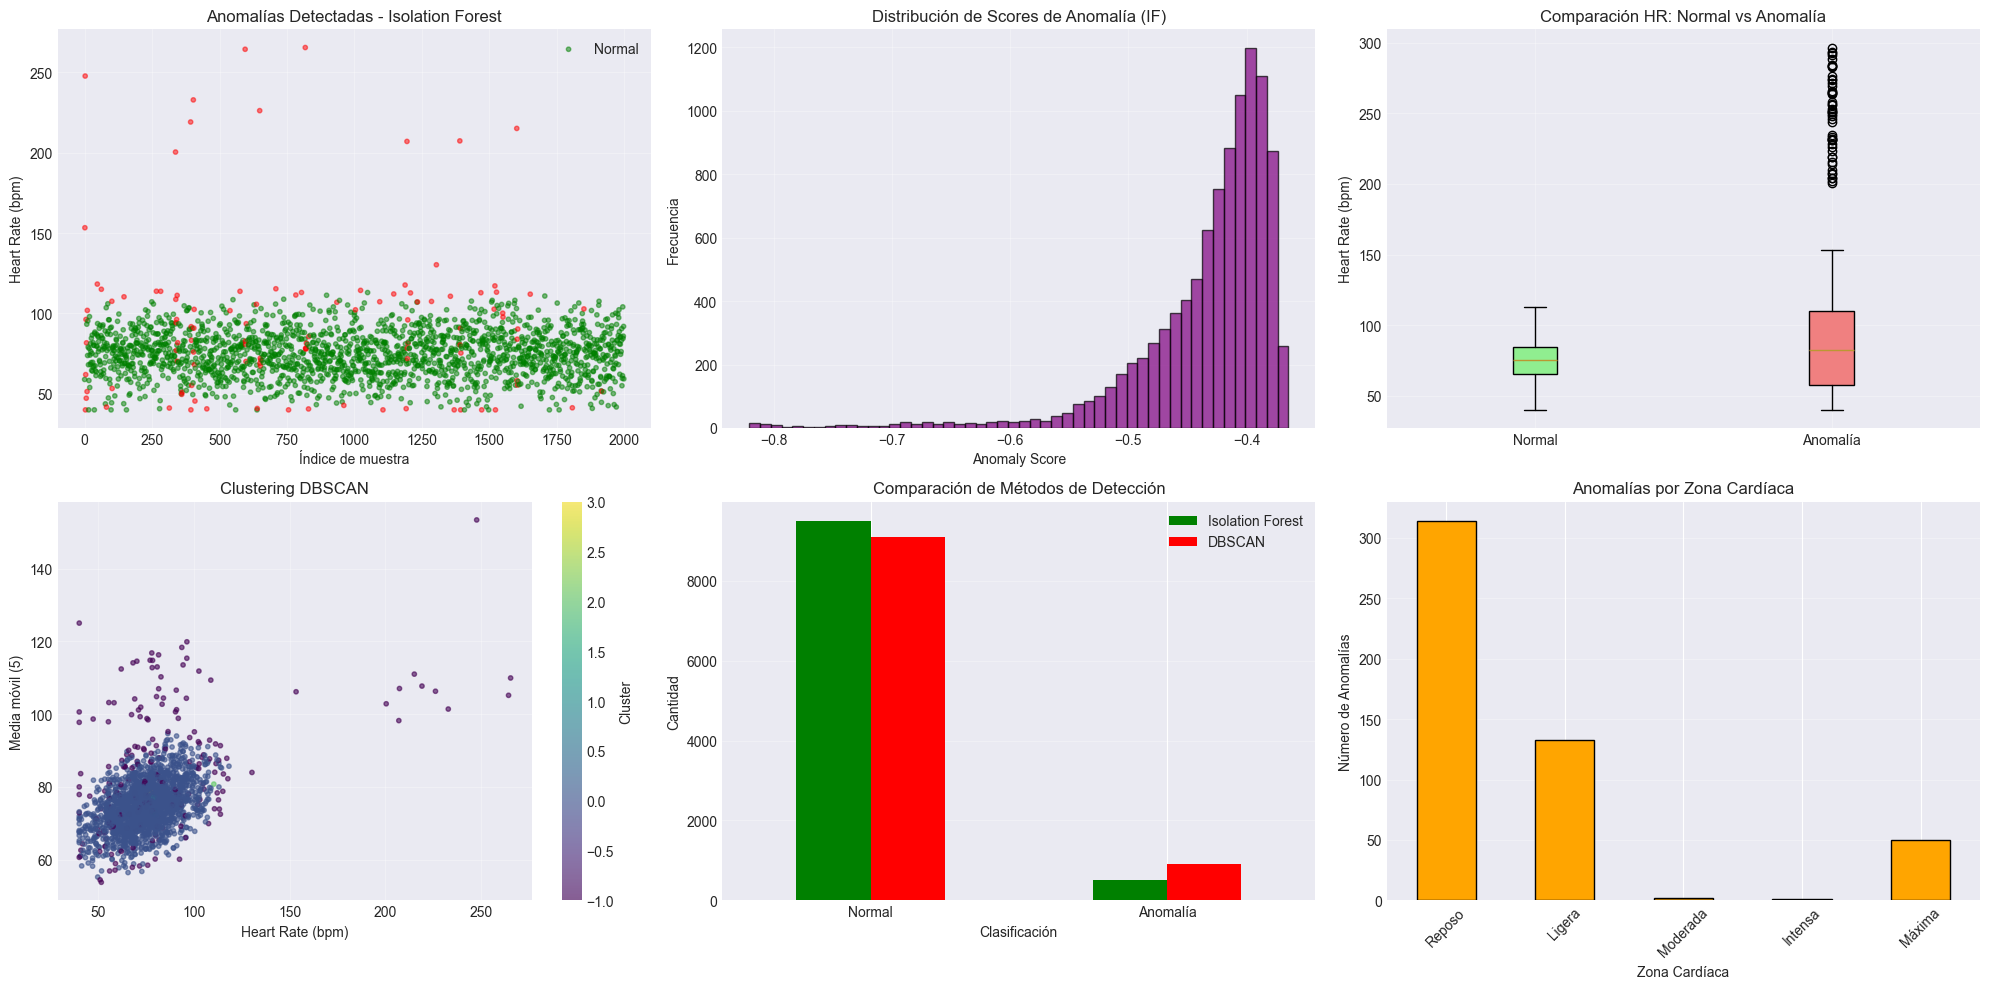


Gráfico guardado como 'anomaly_detection_results.png'


In [94]:
fig = plt.figure(figsize=(20, 10))

# 1. Distribución de anomalías - Isolation Forest
plt.subplot(2, 3, 1)
colors_if = ['green' if x == 0 else 'red' for x in df_clean['is_anomaly_if']]
sample_size = min(2000, len(df_clean))
indices = range(sample_size)
plt.scatter(indices, df_clean['heart_rate'].head(sample_size), 
            c=colors_if[:sample_size], alpha=0.5, s=10)
plt.xlabel('Índice de muestra')
plt.ylabel('Heart Rate (bpm)')
plt.title('Anomalías Detectadas - Isolation Forest')
plt.legend(['Normal', 'Anomalía'], loc='upper right')
plt.grid(True, alpha=0.3)

# 2. Scores de anomalía
plt.subplot(2, 3, 2)
plt.hist(df_clean['anomaly_score_if'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('Anomaly Score')
plt.ylabel('Frecuencia')
plt.title('Distribución de Scores de Anomalía (IF)')
plt.grid(True, alpha=0.3)

# 3. Boxplot comparativo
plt.subplot(2, 3, 3)
data_to_plot = [df_clean[df_clean['is_anomaly_if'] == 0]['heart_rate'],
                df_clean[df_clean['is_anomaly_if'] == 1]['heart_rate']]
bp = plt.boxplot(data_to_plot, labels=['Normal', 'Anomalía'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
plt.ylabel('Heart Rate (bpm)')
plt.title('Comparación HR: Normal vs Anomalía')
plt.grid(True, alpha=0.3)

# 4. Clusters DBSCAN
plt.subplot(2, 3, 4)
scatter = plt.scatter(df_clean['heart_rate'].head(sample_size), 
                     df_clean['hr_rolling_mean_5'].head(sample_size),
                     c=df_clean['cluster_dbscan'].head(sample_size), 
                     cmap='viridis', alpha=0.6, s=10)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Media móvil (5)')
plt.title('Clustering DBSCAN')
plt.grid(True, alpha=0.3)

# 5. Comparación de métodos
plt.subplot(2, 3, 5)
comparison = pd.DataFrame({
    'Isolation Forest': df_clean['is_anomaly_if'].value_counts(),
    'DBSCAN': df_clean['is_anomaly_dbscan'].value_counts()
})
comparison.plot(kind='bar', ax=plt.gca(), color=['green', 'red'])
plt.xlabel('Clasificación')
plt.ylabel('Cantidad')
plt.title('Comparación de Métodos de Detección')
plt.xticks([0, 1], ['Normal', 'Anomalía'], rotation=0)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3, axis='y')

# 6. Anomalías por zona cardíaca
plt.subplot(2, 3, 6)
anomaly_by_zone = df_clean.groupby('hr_zone')['is_anomaly_if'].sum()
anomaly_by_zone.plot(kind='bar', color='orange', edgecolor='black')
plt.xlabel('Zona Cardíaca')
plt.ylabel('Número de Anomalías')
plt.title('Anomalías por Zona Cardíaca')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('anomaly_detection_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado como 'anomaly_detection_results.png'")

## 10. Sistema de Clasificación de Alertas


SISTEMA DE CLASIFICACIÓN DE ALERTAS

Distribución de Alertas:
alert_label
Normal     5918
Baja       2377
Media      1559
Alta         96
Crítica      50
Name: count, dtype: int64

Porcentajes:
alert_label
Normal     59.18
Baja       23.77
Media      15.59
Alta        0.96
Crítica     0.50
Name: count, dtype: float64


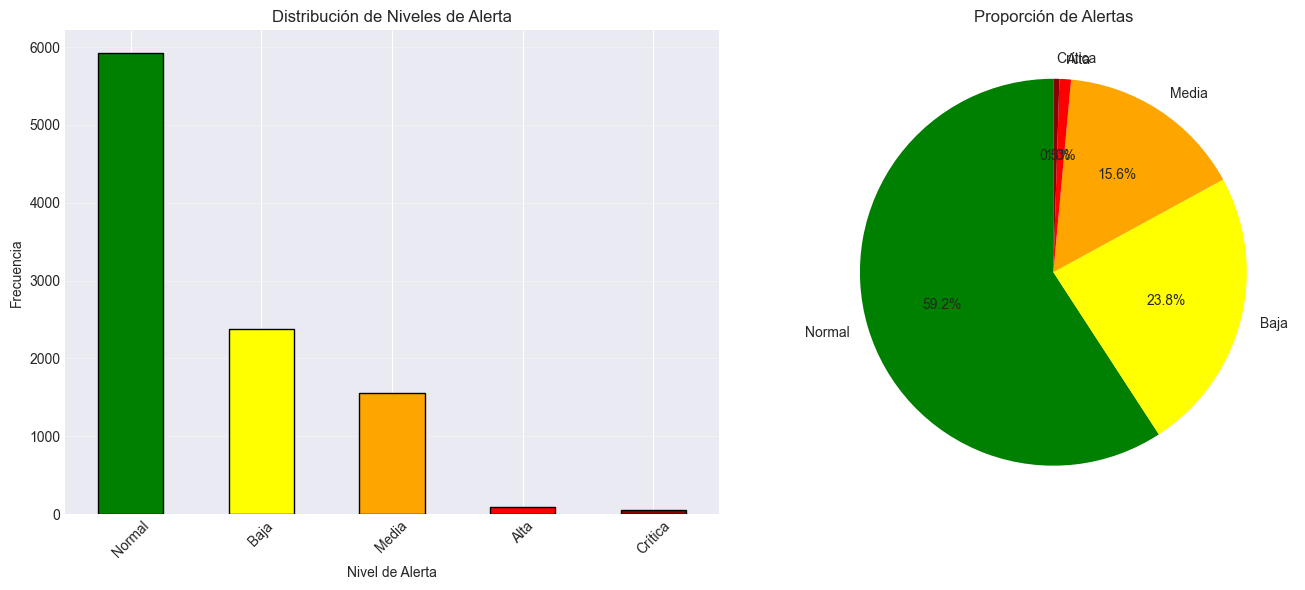


Gráfico guardado como 'alert_classification.png'


In [95]:
print("\n" + "=" * 60)
print("SISTEMA DE CLASIFICACIÓN DE ALERTAS")
print("=" * 60)

# Definir niveles de alerta basados en criterios múltiples
def classify_alert(row):
    """
    Clasifica el nivel de alerta según criterios médicos
    Returns: 0=Normal, 1=Baja, 2=Media, 3=Alta, 4=Crítica
    """
    hr = row['heart_rate']
    is_anomaly = row['is_anomaly_if']
    hr_diff = row['hr_diff_abs']
    
    # Criterios críticos
    if hr < 40 or hr > 180:
        return 4  # Crítica
    
    # Criterios altos
    if is_anomaly == 1 and (hr < 50 or hr > 150):
        return 3  # Alta
    
    # Criterios medios
    if is_anomaly == 1 or hr_diff > 30:
        return 2  # Media
    
    # Criterios bajos
    if hr < 60 or hr > 120 or hr_diff > 20:
        return 1  # Baja
    
    return 0  # Normal

df_clean['alert_level'] = df_clean.apply(classify_alert, axis=1)

# Mapear niveles a etiquetas
alert_labels = {0: 'Normal', 1: 'Baja', 2: 'Media', 3: 'Alta', 4: 'Crítica'}
df_clean['alert_label'] = df_clean['alert_level'].map(alert_labels)

# Estadísticas de alertas
alert_distribution = df_clean['alert_label'].value_counts()
print("\nDistribución de Alertas:")
print(alert_distribution)
print(f"\nPorcentajes:")
print((alert_distribution / len(df_clean) * 100).round(2))

# Visualizar distribución de alertas
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors_alert = {0: 'green', 1: 'yellow', 2: 'orange', 3: 'red', 4: 'darkred'}
alert_colors = [colors_alert[i] for i in sorted(df_clean['alert_level'].unique())]
bars = alert_distribution.plot(kind='bar', color=alert_colors, edgecolor='black')
plt.xlabel('Nivel de Alerta')
plt.ylabel('Frecuencia')
plt.title('Distribución de Niveles de Alerta')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 2, 2)
plt.pie(alert_distribution.values, labels=alert_distribution.index, autopct='%1.1f%%',
        colors=alert_colors,
        startangle=90)
plt.title('Proporción de Alertas')

plt.tight_layout()
plt.savefig('alert_classification.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado como 'alert_classification.png'")

## 11. Modelo Predictivo con Random Forest

In [96]:
print("\n" + "=" * 60)
print("MODELO 3: RANDOM FOREST CLASSIFIER")
print("=" * 60)

# Crear variable objetivo binaria (alerta sí/no)
df_clean['requires_alert'] = (df_clean['alert_level'] >= 2).astype(int)

# Preparar datos
X_rf = df_clean[feature_columns].copy()
y_rf = df_clean['requires_alert'].copy()

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.3, random_state=42, stratify=y_rf
)

# Escalar datos
scaler_rf = StandardScaler()
X_train_scaled = scaler_rf.fit_transform(X_train)
X_test_scaled = scaler_rf.transform(X_test)

# Entrenar Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Métricas
print("\nResultados en conjunto de prueba:")
print(classification_report(y_test, y_pred, target_names=['No Alerta', 'Alerta']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(cm)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportancia de Características:")
print(feature_importance)


MODELO 3: RANDOM FOREST CLASSIFIER

Resultados en conjunto de prueba:
              precision    recall  f1-score   support

   No Alerta       0.99      1.00      1.00      2489
      Alerta       1.00      0.96      0.98       511

    accuracy                           0.99      3000
   macro avg       1.00      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000


Matriz de Confusión:
[[2489    0]
 [  18  493]]

Importancia de Características:
              feature  importance
4         hr_diff_abs    0.663708
2    hr_rolling_std_5    0.140051
1   hr_rolling_mean_5    0.072433
0          heart_rate    0.050625
5  hr_ratio_to_median    0.046735
3  hr_rolling_mean_10    0.026448

Resultados en conjunto de prueba:
              precision    recall  f1-score   support

   No Alerta       0.99      1.00      1.00      2489
      Alerta       1.00      0.96      0.98       511

    accuracy                           0.99      3000
   macro avg       1.00      

## 12. Visualización del Modelo Random Forest

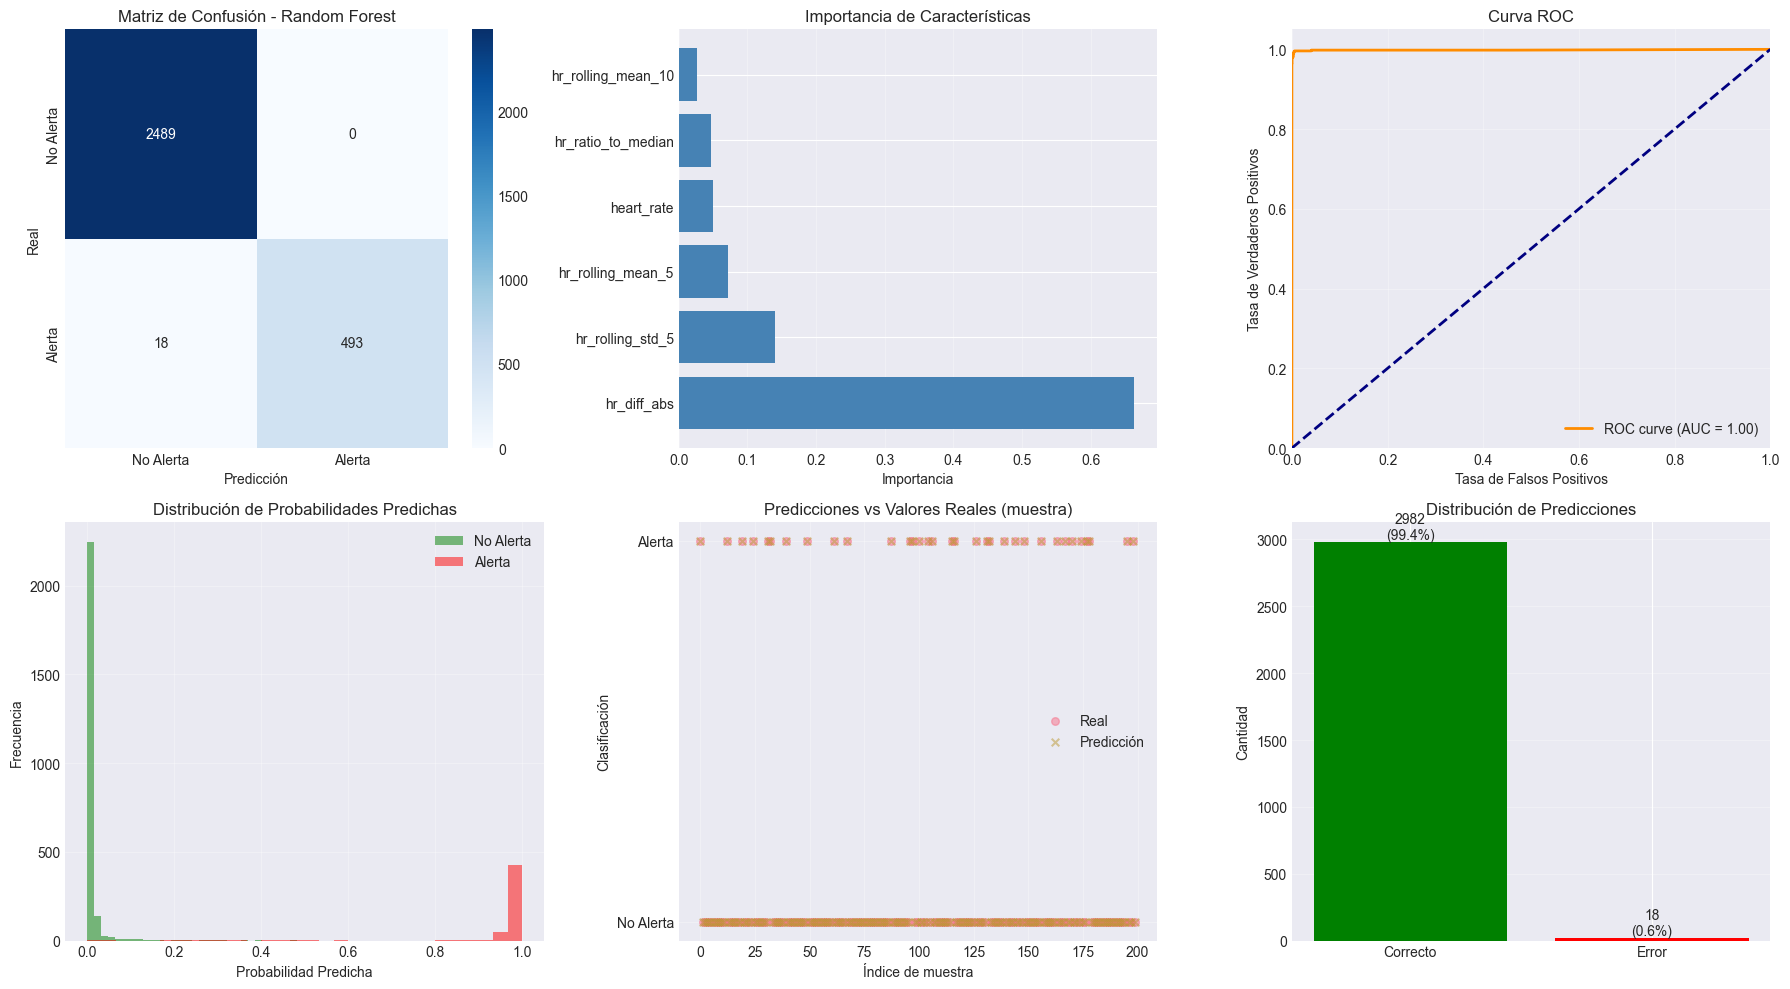


Gráfico guardado como 'random_forest_evaluation.png'


In [97]:
fig = plt.figure(figsize=(18, 10))

# 1. Matriz de Confusión
plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Alerta', 'Alerta'],
            yticklabels=['No Alerta', 'Alerta'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')

# 2. Importancia de características
plt.subplot(2, 3, 2)
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importancia')
plt.title('Importancia de Características')
plt.grid(True, alpha=0.3, axis='x')

# 3. Curva ROC
plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 4. Distribución de probabilidades predichas
plt.subplot(2, 3, 4)
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.5, label='No Alerta', color='green')
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.5, label='Alerta', color='red')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades Predichas')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Predicciones vs Reales (muestra)
plt.subplot(2, 3, 5)
sample_size_viz = min(200, len(y_test))
indices_viz = range(sample_size_viz)
y_test_reset = y_test.reset_index(drop=True)
plt.scatter(indices_viz, y_test_reset.iloc[:sample_size_viz], alpha=0.5, label='Real', s=30)
plt.scatter(indices_viz, y_pred[:sample_size_viz], alpha=0.5, label='Predicción', s=30, marker='x')
plt.xlabel('Índice de muestra')
plt.ylabel('Clasificación')
plt.title('Predicciones vs Valores Reales (muestra)')
plt.legend()
plt.yticks([0, 1], ['No Alerta', 'Alerta'])
plt.grid(True, alpha=0.3)

# 6. Distribución de errores
plt.subplot(2, 3, 6)
errors = (y_test != y_pred).astype(int)
error_dist = pd.Series(errors).value_counts()
plt.bar(['Correcto', 'Error'], error_dist.values, color=['green', 'red'])
plt.ylabel('Cantidad')
plt.title('Distribución de Predicciones')
plt.grid(True, alpha=0.3, axis='y')
# Añadir porcentajes
for i, v in enumerate(error_dist.values):
    plt.text(i, v, f'{v}\n({v/len(errors)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('random_forest_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado como 'random_forest_evaluation.png'")

## 13. Guardado de Modelos y Configuraciones

In [98]:
import pickle

print("\n" + "=" * 60)
print("GUARDANDO MODELOS Y SCALERS")
print("=" * 60)

# Guardar modelos
models_to_save = {
    'isolation_forest': iso_forest,
    'dbscan': dbscan,
    'random_forest': rf_model,
    'scaler': scaler,
    'scaler_rf': scaler_rf
}

for name, model in models_to_save.items():
    filename = f'model_{name}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"✓ Modelo guardado: {filename}")

# Guardar configuración del modelo
model_config = {
    'feature_columns': feature_columns,
    'alert_labels': alert_labels,
    'model_params': {
        'isolation_forest': {
            'contamination': 0.05,
            'n_estimators': 100
        },
        'random_forest': {
            'n_estimators': 100,
            'max_depth': 10
        }
    },
    'hr_thresholds': {
        'critical_low': 40,
        'critical_high': 180,
        'warning_low': 50,
        'warning_high': 150
    }
}

with open('model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)
print("✓ Configuración guardada: model_config.pkl")


GUARDANDO MODELOS Y SCALERS
✓ Modelo guardado: model_isolation_forest.pkl
✓ Modelo guardado: model_dbscan.pkl
✓ Modelo guardado: model_random_forest.pkl
✓ Modelo guardado: model_scaler.pkl
✓ Modelo guardado: model_scaler_rf.pkl
✓ Configuración guardada: model_config.pkl


## 14. Resumen Final y Conclusiones

In [99]:
print("\n" + "=" * 80)
print(" " * 20 + "RESUMEN FINAL DEL ANÁLISIS")
print("=" * 80)

print("\nDATASET:")
print(f"  • Total de muestras analizadas: {len(df_clean):,}")
print(f"  • Características generadas: {len(feature_columns)}")
print(f"  • Rango de HR: {df_clean['heart_rate'].min():.1f} - {df_clean['heart_rate'].max():.1f} bpm")
print(f"  • HR promedio: {df_clean['heart_rate'].mean():.2f} ± {df_clean['heart_rate'].std():.2f} bpm")

print("\nDETECCIÓN DE ANOMALÍAS:")
print(f"  • Isolation Forest: {df_clean['is_anomaly_if'].sum():,} anomalías ({df_clean['is_anomaly_if'].sum()/len(df_clean)*100:.2f}%)")
print(f"  • DBSCAN: {df_clean['is_anomaly_dbscan'].sum():,} anomalías ({df_clean['is_anomaly_dbscan'].sum()/len(df_clean)*100:.2f}%)")
print(f"  • Clusters identificados: {n_clusters}")

print("\nSISTEMA DE ALERTAS:")
for level, label in alert_labels.items():
    count = (df_clean['alert_level'] == level).sum()
    pct = count / len(df_clean) * 100
    print(f"  • {label}: {count:,} ({pct:.2f}%)")

print("\nMODELO PREDICTIVO (Random Forest):")
print(f"  • Accuracy en test: {(y_test == y_pred).sum()/len(y_test)*100:.2f}%")
print(f"  • AUC-ROC: {roc_auc:.3f}")
print(f"  • Característica más importante: {feature_importance.iloc[0]['feature']}")

print("\nARCHIVOS GENERADOS:")
generated_files = [
    'hr_analysis_comprehensive.png',
    'anomaly_detection_results.png',
    'alert_classification.png',
    'random_forest_evaluation.png',
    'model_isolation_forest.pkl',
    'model_dbscan.pkl',
    'model_random_forest.pkl',
    'model_scaler.pkl',
    'model_scaler_rf.pkl',
    'model_config.pkl'
]

for file in generated_files:
    print(f"  ✓ {file}")


                    RESUMEN FINAL DEL ANÁLISIS

DATASET:
  • Total de muestras analizadas: 10,000
  • Características generadas: 6
  • Rango de HR: 40.0 - 296.6 bpm
  • HR promedio: 75.98 ± 19.17 bpm

DETECCIÓN DE ANOMALÍAS:
  • Isolation Forest: 500 anomalías (5.00%)
  • DBSCAN: 917 anomalías (9.17%)
  • Clusters identificados: 8

SISTEMA DE ALERTAS:
  • Normal: 5,918 (59.18%)
  • Baja: 2,377 (23.77%)
  • Media: 1,559 (15.59%)
  • Alta: 96 (0.96%)
  • Crítica: 50 (0.50%)

MODELO PREDICTIVO (Random Forest):
  • Accuracy en test: 99.40%
  • AUC-ROC: 0.998
  • Característica más importante: hr_diff_abs

ARCHIVOS GENERADOS:
  ✓ hr_analysis_comprehensive.png
  ✓ anomaly_detection_results.png
  ✓ alert_classification.png
  ✓ random_forest_evaluation.png
  ✓ model_isolation_forest.pkl
  ✓ model_dbscan.pkl
  ✓ model_random_forest.pkl
  ✓ model_scaler.pkl
  ✓ model_scaler_rf.pkl
  ✓ model_config.pkl


In [100]:
# Guardar también el dataframe procesado para uso futuro
df_clean.to_csv('processed_health_data.csv', index=False)
print("✓ Dataset procesado guardado en 'processed_health_data.csv'")

✓ Dataset procesado guardado en 'processed_health_data.csv'


---

## 15. Integración con Backend Django

###Archivos Generados para el Backend

Este notebook ha generado los siguientes archivos que el backend necesita:

1. **Modelos ML** (`.pkl`):
   - `model_isolation_forest.pkl` - Detección de anomalías
   - `model_random_forest.pkl` - Predicción de alertas
   - `model_dbscan.pkl` - Clustering (opcional)
   - `model_scaler.pkl` - Normalizador de features
   - `model_scaler_rf.pkl` - Normalizador RF
   - `model_config.pkl` - Configuración y umbrales

2. **Módulo de Predicción**:
   - `ml_predictor.py` - Clase Python para usar desde Django
   
3. **Documentación**:
   - `README_ML.md` - Guía completa de integración

Ver `README_ML.md` para más detalles de integración.